## SKU110K Dataset to YOLOv5 Format


> `Date: 02/01/2022`
<br/>
> `Author: @datasith`
<br/>
> `Last Modified:`
<br/>
> `/* name - date */`
<br/>
> `License: https://github.com/datasith/datasith/blob/main/licenses/LICENSE.nsfw`


#### Download and extract the SKU110K dataset

This step will vary by Users' preference. If nothing else, it serves to keep track of the URL where to find the dataset

In [6]:
sku_dataset_folder  = # 'Path to directory where the images were downloaded'
# sku_dataset_folder  = '/Users/datasith/Work/datasets/'

# !wget http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz -P "$sku_dataset_folder"
# !curl http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz --create-dirs -O --output-dir "$sku_dataset_folder"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3G  100 11.3G    0     0  21.8M      0  0:08:52  0:08:52 --:--:-- 21.6M5.8M:00:19  0:07:48 26.5M     0  0:09:17  0:00:39  0:08:38 4821k00:50  0:10:12 7650k2 19.2M10:29  0:01:13  0:09:16 20.1M7M      0  0:09:48  0:01:33  0:08:15 28.4M  0:09:41  0:01:35  0:08:06 29.5M     0  0:09:39  0:01:44  0:07:55 19.9M   0  0:09:38  0:01:48  0:07:50 20.4M     0  0:09:32  0:02:00  0:07:32 23.5M9:41  0:02:42  0:06:59 21.3M0:02:44  0:06:59 18.9M0:09:54  0:03:02  0:06:52 17.3M0  0:09:26  0:03:58  0:05:28 25.2M    0  0:09:21  0:04:07  0:05:14 24.7M0.7M      0  0:09:20  0:04:09  0:05:11 24.1M     0  0:09:05  0:04:43  0:04:22 22.0M  0:09:07  0:05:05  0:04:02 21.5M4M      0  0:09:02  0:05:15  0:03:47 30.0M   0  0:08:59  0:05:51  0:03:08 21.9M8  0:06:08  0:02:50 23.1M      0  0:08:58  0:06:12  0:02:46 24.3M1.6M      0  0:08:57  0:06:25  0:02:32 21

In [9]:
# !tar -xf "$sku_dataset_folder"/SKU110K_fixed.tar.gz -C "$sku_dataset_folder" > /dev/null

#### Import necessary libraries

In [10]:
import os
import glob
import pandas as pd
import shutil
from pathlib import Path

#### Set up the dataset's local path

In [11]:
sku_dataset_dirname = 'SKU110K_fixed'
path_images         = Path(sku_dataset_folder) / sku_dataset_dirname / 'images'
path_annotations    = Path(sku_dataset_folder) / sku_dataset_dirname / 'annotations'

In [13]:
# Sanity check
# !ls $path_images

#### Re-organize files into test, train, and validation 

In [14]:
prefix_to_channel = {
    "train": "train",
    "val": "validation",
    "test": "test",
}

assert path_images.exists(), f"{path_images} not found"

for channel_name in prefix_to_channel.values():
    if not (path_images.parent / channel_name).exists():
        (path_images.parent / channel_name).mkdir()

for path_img in path_images.iterdir():
    for prefix in prefix_to_channel:
        if path_img.name.startswith(prefix):
            path_img.replace(
                path_images.parent / prefix_to_channel[prefix] / path_img.name
            )

#### Remove corrupted files

In [15]:
CORRUPTED_IMAGES = {
    "train": ("train_4222.jpg", "train_5822.jpg", "train_882.jpg", "train_924.jpg"),
    "validation": tuple(),
    "test": ("test_274.jpg", "test_2924.jpg"),
}

In [16]:
for channel_name in prefix_to_channel.values():
    for img_name in CORRUPTED_IMAGES[channel_name]:
        try:
            (path_images.parent / channel_name / img_name).unlink()
            print(f"{img_name} removed from channel {channel_name} ")
        except FileNotFoundError:
            print(f"{img_name} not in channel {channel_name}")

train_4222.jpg removed from channel train 
train_5822.jpg removed from channel train 
train_882.jpg removed from channel train 
train_924.jpg removed from channel train 
test_274.jpg removed from channel test 
test_2924.jpg removed from channel test 


In [17]:
# Expected output:
# Number of train images = 8215
# Number of validation images = 588
# Number of test images = 2934
for channel_name in prefix_to_channel.values():
    print(
        f"Number of {channel_name} images = {sum(1 for x in (path_images.parent / channel_name).glob('*.jpg'))}"
    )

Number of train images = 8215
Number of validation images = 588
Number of test images = 2934


In [18]:
os.rmdir(path_images)

#### Reformat label (annotations) data

Taking the snipped of code from `./yolov5/data/SKU-110K.yaml` and modifying it for our use case

In [19]:
yolov5_dataset_folder = os.getcwd()
yolov5_sku_dataset_dirname = 'SKU110K_fixed'
local_path_annotations = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'labels'
local_path_images = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'images'

In [21]:
!mkdir -p $local_path_annotations $local_path_images

The original format of the `SKU110K` dataset is:

`'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'`

We need to convert it to `YOLO` format, which is:

`'class', 'x1', 'y1', 'x2', 'y2'`

We also need to normalize the bounding box coordinates as expected by the model

In [22]:
names = 'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'
annotation_files =  path_annotations.glob('*.csv')
for file in annotation_files:
    print(file)
    data = pd.read_csv(file, names=names)  # annotations
    prefix = file.name.split('_')[-1].replace('.csv','')
    out_labels_dir = local_path_annotations / prefix
    out_images_dir = local_path_images / prefix

    isExist = os.path.exists(out_labels_dir)
    if not isExist:
        os.mkdir(out_labels_dir)

    isExist = os.path.exists(out_images_dir)
    if not isExist:
        os.mkdir(out_images_dir)
        
    for filename_img in data['image'].unique():
        # Get all bounding boxes for this image
        mask_filename_img = data['image'] == filename_img
        data_img = data[mask_filename_img].copy().reset_index()

        # Reformat each bounding box and add it to output file
        # YOLO format is normalized (img_width, img_height) = (1, 1)
        width = data_img.image_width[0]
        height = data_img.image_height[0]
        data_img['x1'] = data_img['x1'] / width
        data_img['y1'] = data_img['y1'] / height
        data_img['x2'] = data_img['x2'] / width
        data_img['y2'] = data_img['y2'] / height
        data_img['class'] = 0
        
        data_img = data_img[['class','x1','y1','x2','y2']]

        # Set up the necessary paths
        filename_label = filename_img.replace('jpg','txt')
        out_labels_file = out_labels_dir / filename_label
        in_images_file = path_images.parent / prefix_to_channel[prefix] / filename_img
        out_images_file = out_images_dir / filename_img

        try:
            _ = shutil.copy2(in_images_file, out_images_file)
        except:
            # Exceptions are due to image file not existing for the corresponding label
            # raise NameError('check the image file name')
            print(f'check the image file name {filename_img}') 
            continue

        # If the image file is found and copied, it's safe to generate the corresponding label file
        data_img.to_csv(out_labels_file , sep=' ', header=False, index=False)

/Users/datasith/Work/datasets/SKU110K_fixed/annotations/annotations_test.csv
check the image file name test_274.jpg
check the image file name test_2924.jpg
/Users/datasith/Work/datasets/SKU110K_fixed/annotations/annotations_val.csv
/Users/datasith/Work/datasets/SKU110K_fixed/annotations/annotations_train.csv
check the image file name train_4222.jpg
check the image file name train_5822.jpg
check the image file name train_882.jpg
check the image file name train_924.jpg


#### Visualize saved annotations

/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/train/train_2878.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/train/train_2878.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/train/train_1995.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/train/train_1995.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/train/train_4335.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/train/train_4335.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/val/val_125.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/val/val_125.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/val/val_100.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/val/val_100.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/val/val_472.jpg
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/labels/val/val_472.txt
/Users/datasith/Work/datasets-sku110k/SKU110K_fixed/images/test/test_2

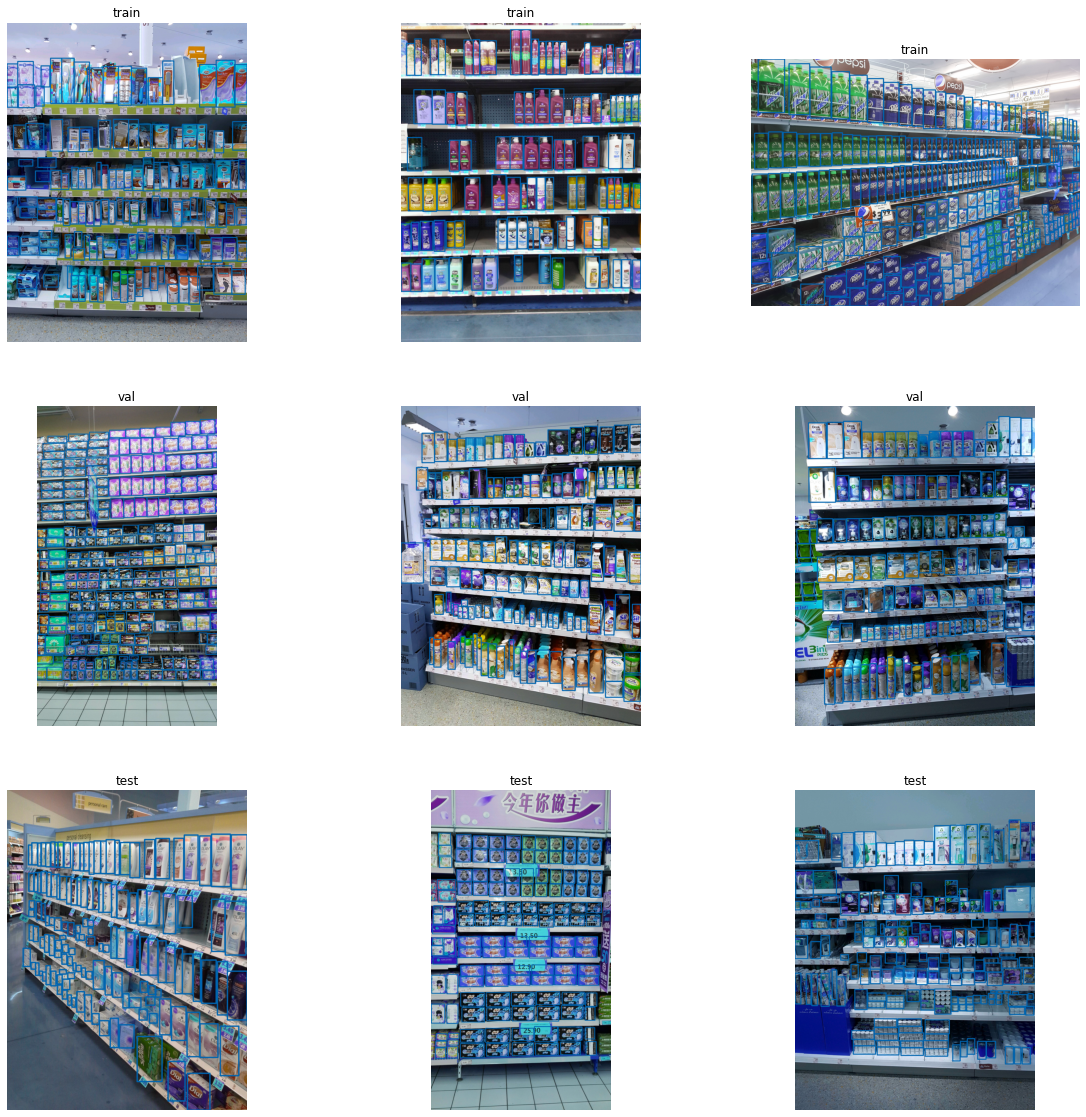

In [71]:
counter = 1
plt.figure(figsize=(20, 20), facecolor='white')

for prefix in prefix_to_channel:
    _path = local_path_images / prefix / '*'
    local_files_images = glob.glob(_path.as_posix())
    for idx in random.sample(range(0, len(local_files_images)), 3):
        filename_image = local_files_images[idx]
        filename_label = filename_image.replace('images','labels').replace('jpg','txt')
        data = pd.read_csv(filename_label, header=None, delimiter=' ')
        
        print(filename_image)
        print(filename_label)
        im = cv2.imread(filename_image)
        im_size = im.shape[:2]
        for _, bbox in data.iterrows():
            cls, xmin, ymin, xmax, ymax = bbox
            xmin = xmin*im_size[1]
            ymin = ymin*im_size[0]
            xmax = xmax*im_size[1]
            ymax = ymax*im_size[0]

            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color = (0, 100, 175)
            thickness = 10

            im = cv2.rectangle(im, start_point, end_point, color, thickness)

        ax = plt.subplot(3, 3, counter)
        plt.title(prefix)
        plt.axis("off")
        plt.imshow(im)
        counter += 1